# **Instructions for Assignment 7**
*Hyperparameter Tuning of a Deep MLP on the MNIST Dataset Using Keras Tuner*

In this assignment, you will work with the MNIST dataset to develop a deep Multi-Layer Perceptron (MLP) model. Using Keras Tuner, you will search for the best hyperparameters to optimize the MLP model's performance, aiming to achieve a test accuracy of at least 98%. Your task is to explore different configurations of the MLP model, analyze the tuning results, and identify the optimal hyperparameter values.

Assignment Instructions:

- **Train a Deep MLP Model on the MNIST Dataset:** Set up a deep MLP model for classifying handwritten digits from the MNIST dataset. 

- **Hyperparameter Tuning with Keras Tuner:** Use Keras Tuner to perform hyperparameter tuning on the model. Search for optimal values of key hyperparameters, such as, number of Hidden Layers and units in a hidden layer, learning rate, and batch size. Configure Keras Tuner to use Random Search to find the best hyperparameter values.

- **Analyze the Tuning Results:** Once tuning is complete, evaluate the model’s performance with the best-found hyperparameters on the test set. Present results, including metrics such as accuracy, training time, and convergence rate. Discuss the chosen hyperparameters and explain how they contributed to achieving high accuracy on the MNIST dataset.

- **Comparison with Baseline Model (Optional)**
Optionally, compare the tuned MLP model's accuracy with the models we used for classification in our early labs on classification for MNIST dataset. Analyze and discuss the improvement in the performance.

<span style="color:red; font-weight:bold;">IMPORTANT INFORMATION:</span>

This notebook contains the code used to obtain the results from the lab report.  
However, it is important to highlight that it does not reproduce the *exact same results*,  
since it was re-run later without saving the previous version.
ed but it is not included here. 

## **Import libraries and dataset**

In [1]:
# ======================================================
# Deep MLP on MNIST + Hyperparameter Tuning with Keras Tuner
# ======================================================

import sys
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt

# --- Version checks ---
assert sys.version_info >= (3, 6)
assert tf.__version__ >= "2.0"

# --- Reproducibility ---
np.random.seed(42)
tf.random.set_seed(42)

# --- Load MNIST dataset ---
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

# Normalize (0–255) → (0–1)
X_train_full = X_train_full.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Split validation set
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

## **Build model function for Keras Tuner**

In [13]:
# --- Build model function for Keras Tuner ---
def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))

    # Tune hidden layers
    n_hidden = hp.Int("n_hidden", min_value=2, max_value=5, step=1)
    for i in range(n_hidden):
        units = hp.Int(f"units_{i}", min_value=15, max_value=256, step=25)
        model.add(keras.layers.Dense(units, activation="relu"))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(rate=hp.Float(f"dropout_{i}", 0.2, 0.5, step=0.1)))

    model.add(keras.layers.Dense(10, activation="softmax"))

    # Tune optimizer and learning rate
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop"])
    if optimizer_choice == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# --- Set up Keras Tuner ---
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=15,          
    executions_per_trial=1,
    directory="mnist_tuning_v3",
    project_name="mlp_optimized"
)

c:\Users\pablo\Desktop\HV\Introduction to Artificial Intelligence and Machine Learning\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## **Perform hyperparameter search**

In [ ]:
# --- Perform hyperparameter search ---

tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=5)]
)

# --- Retrieve the best model ---
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n✅ Best Hyperparameters Found:")
print(f"Number of hidden layers: {best_hps.get('n_hidden')}")
for i in range(best_hps.get('n_hidden')):
    print(f" - Units in layer {i+1}: {best_hps.get(f'units_{i}')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Trial 9 Complete [00h 02m 51s]
val_accuracy: 0.9819999933242798

Best val_accuracy So Far: 0.9825999736785889
Total elapsed time: 00h 15m 34s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
4                 |2                 |n_hidden
165               |215               |units_0
0.2               |0.4               |dropout_0
15                |240               |units_1
0.3               |0.3               |dropout_1
0.0010731         |0.0016883         |learning_rate
adam              |rmsprop           |optimizer
115               |15                |units_2
0.4               |0.3               |dropout_2
90                |140               |units_3
0.4               |0.3               |dropout_3
15                |40                |units_4
0.2               |0.3               |dropout_4

Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7632 - loss: 0.7621 - val_accuracy: 0.9470 - val_loss: 0.1797
Epoch 2/50
1719/1719 ━━━━━━━━

## **Train the best model on the full training data**

In [4]:
# --- Train the best model on the full training data ---
history = best_model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=5)]
)

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9863 - loss: 0.0434 - val_accuracy: 0.9852 - val_loss: 0.0692
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9872 - loss: 0.0435 - val_accuracy: 0.9856 - val_loss: 0.0685
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9883 - loss: 0.0382 - val_accuracy: 0.9870 - val_loss: 0.0653
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9883 - loss: 0.0398 - val_accuracy: 0.9846 - val_loss: 0.0757
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9882 - loss: 0.0388 - val_accuracy: 0.9858 - val_loss: 0.0672
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9878 - loss: 0.0377 - val_accuracy: 0.9856 - val_loss: 0.0666
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9882 - loss: 0.0377 - val_accuracy: 0.9858 - val_loss: 0.0680
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9890 - loss: 0.0359 - 

## **Evaluate on test set**

In [5]:
# --- Evaluate on test set ---
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"\n📊 Test accuracy: {test_acc:.4f}")
print(f"📉 Test loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9837 - loss: 0.0737

📊 Test accuracy: 0.9837
📉 Test loss: 0.0737


## **Visualitation and analysis**

### Learning curve for the choosen model:

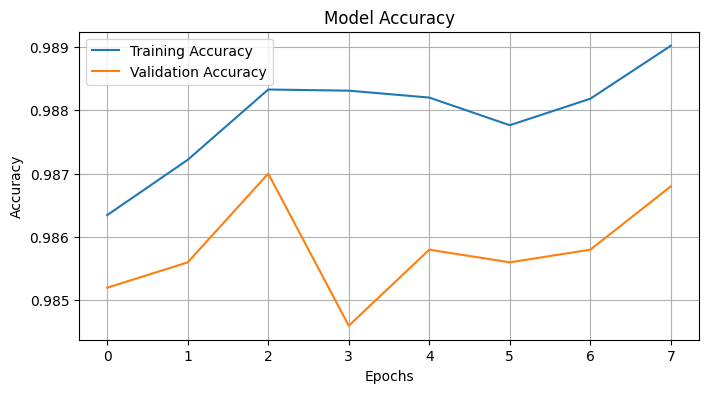

In [6]:
# --- Plot training curves ---
plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Wanted to show how the accruacy value for the randomsearch trials change as the hyperparameters change:

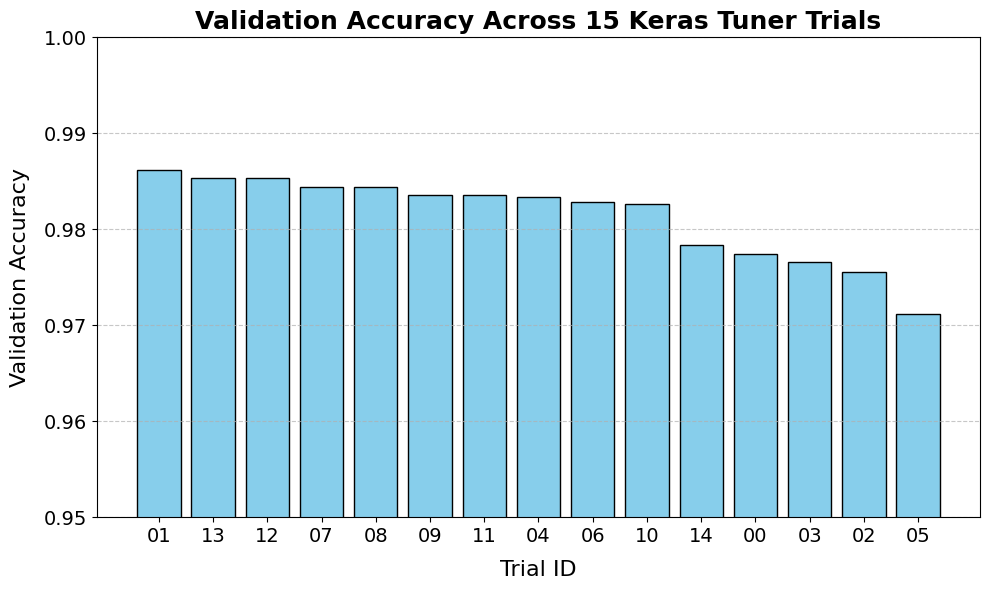

   Trial  Validation Accuracy
0     01               0.9862
1     13               0.9854
2     12               0.9854
3     07               0.9844
4     08               0.9844
5     09               0.9836
6     11               0.9836
7     04               0.9834
8     06               0.9828
9     10               0.9826
10    14               0.9784
11    00               0.9774
12    03               0.9766
13    02               0.9756
14    05               0.9712


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Get all the trials from the tuner results
tuner_results = tuner.oracle.get_best_trials(num_trials=15)

# Extract validation accuracy from each trial
val_accuracies = [trial.metrics.get_last_value('val_accuracy') for trial in tuner_results]
trial_ids = [trial.trial_id for trial in tuner_results]

# Create a DataFrame for clarity
df = pd.DataFrame({
    'Trial': trial_ids,
    'Validation Accuracy': val_accuracies
}).sort_values(by='Validation Accuracy', ascending=False).reset_index(drop=True)

# --- Plot with larger axis values ---
plt.figure(figsize=(10,6))
plt.bar(df['Trial'], df['Validation Accuracy'], color='skyblue', edgecolor='black')

plt.title('Validation Accuracy Across 15 Keras Tuner Trials', fontsize=18, fontweight='bold')
plt.xlabel('Trial ID', fontsize=16, labelpad=10)
plt.ylabel('Validation Accuracy', fontsize=16, labelpad=10)

# Make tick labels larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Grid and limits
plt.ylim(0.95, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print the sorted results
print(df)



### Here I just prepare a data set with the information of the trials, I wanted to look deeper into it and find if there is interesting correlations between the features and the validation accuracy.

In [8]:
# Get all trials
trials = tuner.oracle.trials.values()

# Extract relevant information
records = []
for t in trials:
    trial_id = t.trial_id
    metrics = t.metrics.get_last_value("val_accuracy")
    params = t.hyperparameters.values
    params["trial_id"] = trial_id
    params["val_accuracy"] = metrics
    records.append(params)

# Create DataFrame
df_params = pd.DataFrame(records)

# Sort by best accuracy
df_params = df_params.sort_values(by="val_accuracy", ascending=False).reset_index(drop=True)



### Plot the correlations between all the parameters including the validation accuracy.

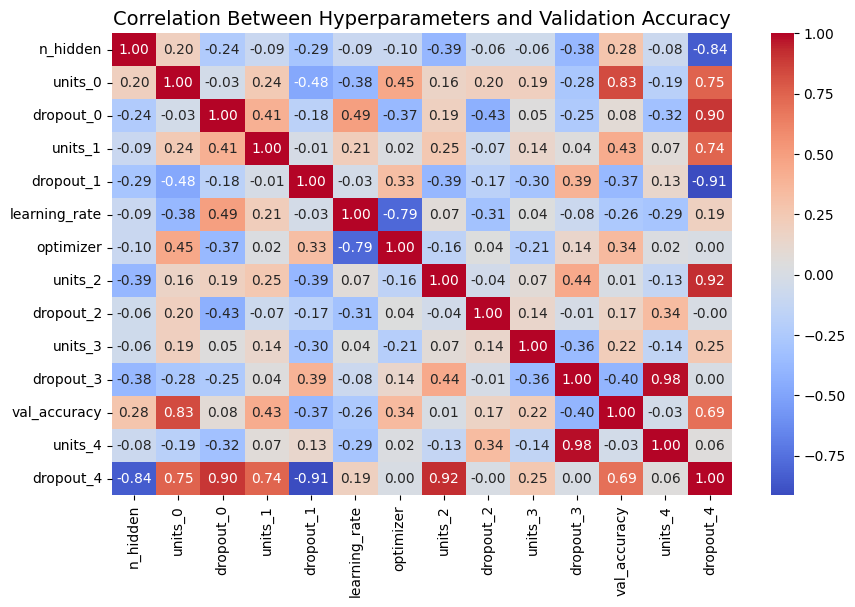

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert categorical optimizer names to numeric for correlation
df_corr = df_params.copy()
df_corr["optimizer"] = df_corr["optimizer"].astype("category").cat.codes

# Compute correlation
corr = df_corr.corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Hyperparameters and Validation Accuracy", fontsize=14)
plt.show()


### Since last plot was a bit to much information, I decided to separate and as I wanted just plot the correlation of the parameters and validation accuracy:

C:\Users\pablo\AppData\Local\Temp\ipykernel_11796\2859265304.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_corr.values, y=val_corr.index, palette="coolwarm")


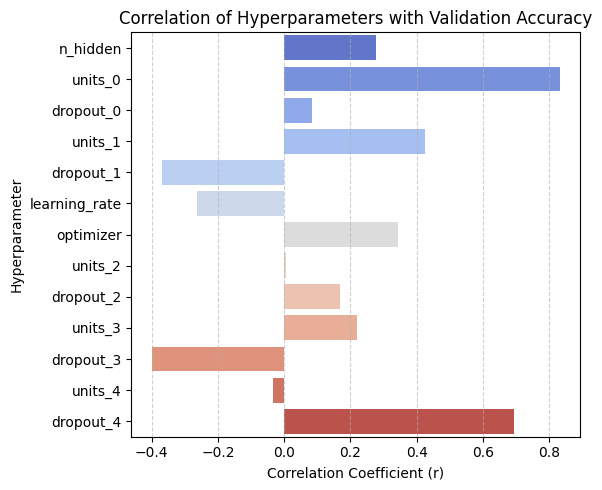

In [10]:
# Use the dataframe that contains all hyperparameters and 'val_accuracy'
# (the notebook stores that as `df_params`)
df_num = df_params.copy()

# Convert categorical optimizer to numeric codes so it can be included in correlations
if "optimizer" in df_num.columns:
	df_num["optimizer"] = df_num["optimizer"].astype("category").cat.codes

# Look for a column that represents validation accuracy (robust to naming)
val_candidates = ["val_accuracy", "Validation Accuracy", "val accuracy", "val_acc"]
val_col = next((c for c in val_candidates if c in df_num.columns), None)
if val_col is None:
	raise KeyError("No column named 'val_accuracy' or equivalent found in df_params")

# Compute correlations using numeric columns
corr = df_num.corr(numeric_only=True)

# Select correlations with the validation accuracy column (drop self-correlation)
val_corr = corr[val_col].drop(labels=[val_col], errors="ignore")

# --- Plot ---
plt.figure(figsize=(6, 5))
sns.barplot(x=val_corr.values, y=val_corr.index, palette="coolwarm")

plt.title("Correlation of Hyperparameters with Validation Accuracy")
plt.xlabel("Correlation Coefficient (r)")
plt.ylabel("Hyperparameter")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
